# Day 29 : EDA + Baseline Model

https://www.kaggle.com/aiswaryaramachandran/eda-baseline-model-0-40-rmse

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle

In [10]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
test.shape

(625134, 9)

## Data Preprocessing

### Convert to appropriate datatype

승차일시와 하차일시를 date-time 객체로 변환

In [18]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


### check any missing values in the data

In [19]:
train[pd.isnull(train)].sum()

id                      0
vendor_id             0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag      0
trip_duration         0.0
dtype: object

결측값이 없다.

### Check the time period of the dataset

In [20]:
print('Min pickup time :', min(train['pickup_datetime']))
print('Max pickup time :', max(train['pickup_datetime']))

Min pickup time : 2016-01-01 00:00:17
Max pickup time : 2016-06-30 23:59:39


데이터는 2016년 1월부터 6월까지 택시 여행 데이터의 6달이다.

### Create new day, month, hour info from Pickup time

In [21]:
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_day'] = train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour'] = train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week'] = train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

train['dropoff_date'] = train['dropoff_datetime'].dt.date
train['dropoff_day'] = train['dropoff_datetime'].apply(lambda x:x.day)
train['dropoff_hour'] = train['dropoff_datetime'].apply(lambda x:x.hour)
train['dropoff_day_of_week'] = train['dropoff_datetime'].apply(lambda x:calendar.day_name[x.weekday()])

### Round lat lng to 3 decimal places (소수점 3자리)

In [22]:
train['pickup_latitude_round3'] = train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3'] = train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3'] = train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3'] = train['dropoff_longitude'].apply(lambda x:round(x,3))
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973


### Based on Latitude and Longitude get the distance of the trip in km

Haversine 거리를 사용한다.

In [23]:
def calculateDistance(row):
    R = 6373.0  # 지구 반지름 km의 근사값
    pickup_lat = radians(row['pickup_latitude'])
    pickup_lon = radians(row['pickup_longitude'])
    dropoff_lat = radians(row['dropoff_latitude'])
    dropoff_lon = radians(row['dropoff_longitude'])
    dlon = dropoff_lon - pickup_lon  ### 하차-승차 직선 거리
    dlat = dropoff_lat - pickup_lat
    a = sin(dlat/2)**2 + cos(pickup_lat) * cos(dropoff_lat) * sin(dlon/2)**2
    c = 2*atan2(sqrt(a), sqrt(1-a))
    distance = R*c
    return distance

In [25]:
train['trip_distance'] = train.apply(lambda row:calculateDistance(row),axis=1)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_day_of_week,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,Monday,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,Sunday,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,Tuesday,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,Wednesday,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,Saturday,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962


In [26]:
train['trip_duration_in_hour'] = train['trip_duration'].apply(lambda x: x/3600) 
train.head()   ### trip_duration : 초단위 -> /3600으로 시간단위로 변경

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,14,17,Monday,40.768,-73.982,40.766,-73.965,1.498991,0.126389
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,12,0,Sunday,40.739,-73.980,40.731,-73.999,1.806074,0.184167
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,19,12,Tuesday,40.764,-73.979,40.710,-74.005,6.387103,0.590000
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,6,19,Wednesday,40.720,-74.010,40.707,-74.012,1.485965,0.119167
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,26,13,Saturday,40.793,-73.973,40.783,-73.973,1.188962,0.120833


## Exploratory Analysis

Text(0.5, 0, 'Trip Duration (in hour)')

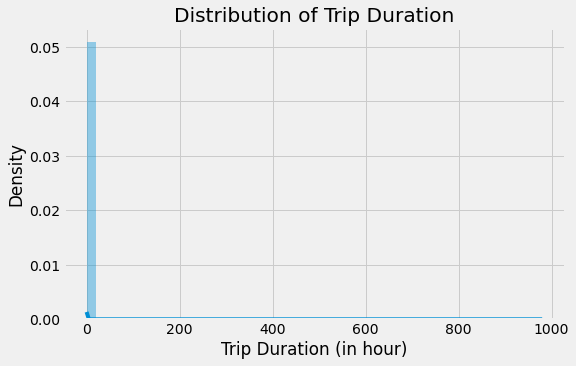

In [27]:
plt.figure(figsize=(8,5))
sns.distplot(train['trip_duration_in_hour']).set_title('Distribution of Trip Duration')
plt.xlabel('Trip Duration (in hour)')

24시간보다 긴 여행 시간이 있다. 이걸 조사해야할까?

In [29]:
outlier_trip_duration = train.loc[train['trip_duration_in_hour'] > 24]
outlier_trip_duration

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dropoff_date,dropoff_day,dropoff_hour,dropoff_day_of_week,pickup_latitude_round3,pickup_longitude_round3,dropoff_latitude_round3,dropoff_longitude_round3,trip_distance,trip_duration_in_hour
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,...,2016-01-27,27,11,Wednesday,40.644,-73.790,40.773,-73.957,20.154989,538.815556
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,...,2016-03-08,8,15,Tuesday,40.735,-73.922,40.760,-73.985,5.984365,569.327222
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,...,2016-01-31,31,1,Sunday,40.742,-73.984,40.728,-73.985,1.635641,618.781111
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,...,2016-03-25,25,18,Friday,40.649,-73.784,40.750,-73.978,19.906909,979.522778


여행 시간이 매우 긴 4개의 레코드가 있지만 여행 거리는 매우 짧다. 이상치다. 하지만 이 여행이 시작되거나 끝나는 특정 장소가 있을까? 여행 시간도 왜곡되어 있어 로그 변환을 취해보자.

이러한 데이터는 test 데이터의 일부일 수 있으므로 분석에서 제거하지 않는다.

Text(0.5, 1.0, 'Distribution of trip duration (sec) in Log Scale')

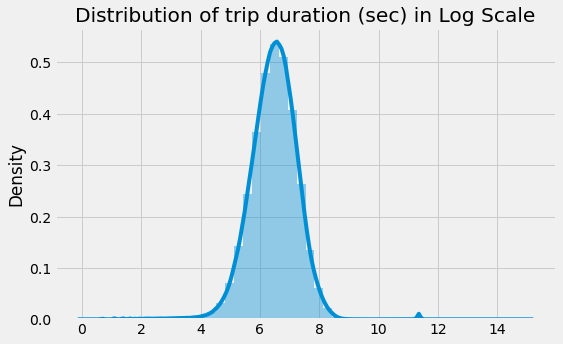

In [30]:
plt.figure(figsize=(8,5))
sns.distplot(np.log(train['trip_duration'].values)).set_title('Distribution of Trip Duration')
plt.title('Distribution of trip duration (sec) in Log Scale')

여행 시간의 로그 변환은 정규 분포를 따른다. 대부분의 여행은 54초(exp(4))와 2980초(exp(8)) 사이다. 이는 디부분의 여행이 한 시간 이내임을 나타낸ㄴ다. 하지만 1분도 안 되는 여행이 있으므로 자세히 살펴보아야한다. 택시 승차가 뉴욕 내에서 이뤄지므로 이상한 100시간 지속되는 여행들이 있다.

### Heatmap of common locations from where pickup and dropoff occurs

In [31]:
pickup = train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [51]:
pickup_map = folium.Map(location=[40.730610,-73.935242], zoome_start=10)
# 각 승차지점에 원형표시 추가
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, np.array(pickup.Num_Trips.values).astype('float64'))),
                  min_opacity=0.5, radius=5, blur=10, max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

(-74.03, -73.75)

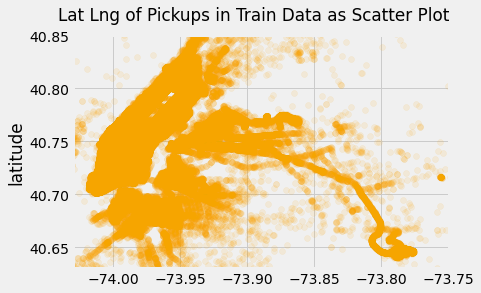

In [46]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, sharex=True, sharey=True)
ax.scatter(train['pickup_longitude'], train['pickup_latitude'], color='orange', label='train', alpha=0.1)

fig.suptitle('Lat Lng of Pickups in Train Data as Scatter Plot')
ax.set_ylabel('latitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)

이 그래프는 JFK 근처에서 승차 밀도가 높다는 것을 분명히 보여준다.

In [47]:
drop = train.groupby(['dropoff_latitude_round3', 'dropoff_longitude_round3'])['id'].count().reset_index().rename(columns={'id':'Num_Trips'})

In [50]:
drop_map = folium.Map(location=[40.730610,-73.935242], zoom_start=10)

hm_wide = HeatMap(list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, np.array(drop.Num_Trips.values).astype('float64'))),
                  min_opacity=0.5, radius=5, blur=10, max_zoom=1)
drop_map.add_child(hm_wide)
drop_map

Dropoff 히트맵은 pickup 히트맵과 비슷하다.

### heatmap of trip duration, when pickup originates from a point

In [63]:
pickup = train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['trip_duration'].mean().reset_index().rename(
    columns={'trip_duration':'Avg_Trip_duration'})

In [65]:
pickup_map = folium.Map(location=[40.730610,-73.935242], zoom_start=10)
hm_wide = HeatMap(list(zip(pickup.pickup_latitude_round3.values, pickup.pickup_longitude_round3.values, np.array(pickup.Avg_Trip_duration.values).astype('float64'))),
                 min_opacity=0.5, radius=7, blur=10, max_zoom=1)
pickup_map.add_child(hm_wide)
pickup_map

평균 여행 시간은 JFK에서 출발한 경우 더 높다. 확대해보면 맨하튼 다음으로 JFK에서의 승차가 여행 시간이 더 많은 경향이 있다.

### Which hours are pickup and dropoff higher?

Text(0.5, 1.0, 'Pickup Hours Distribution')

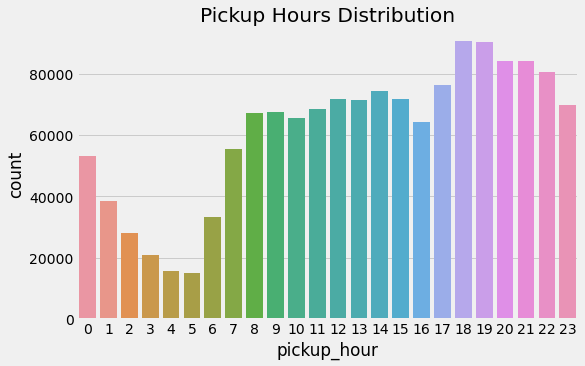

In [66]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['pickup_hour']).set_title('Pickup Hours Distribution')

승차는 이름 아침에 훨씬 더 적다. 대부분의 승차는 오후 6~8시 사이에 가장 높다.

Text(0.5, 1.0, 'Dropoff Hours Distribution')

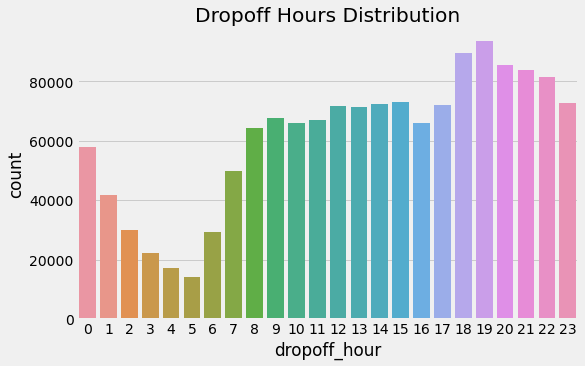

In [67]:
plt.figure(figsize=(8,5))
sns.countplot(x=train['dropoff_hour']).set_title('Dropoff Hours Distribution')

하차 시간 분포도 승차 시간 분포와 거의 비슷하다.

### Pickups over the entire time period

Text(0.5, 1.0, 'Distribution of Pickups over time')

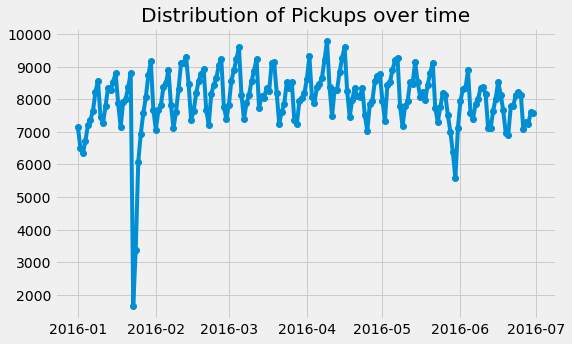

In [70]:
plt.figure(figsize=(8,5))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.title('Distribution of Pickups over time')  ### 시간별 분포

2016년 1월 말 승차 건수가 감소했다.

### Distribution of Trip distance

Text(0.5, 0, 'Trip Distance (log)')

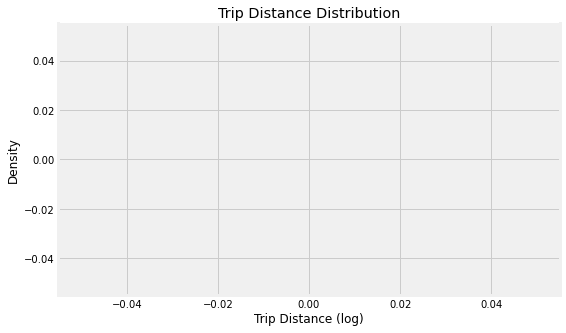

In [82]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['trip_distance'].values)).set_title('Trip Distance Distribution')
plt.xlabel('Trip Distance (log)')

### Trip Duration vs Trip Distance

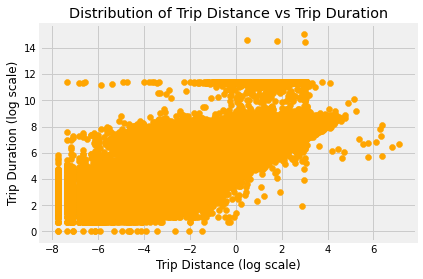

In [84]:
plt.scatter(np.log(train['trip_distance'].values), np.log(train['trip_duration'].values), color='orange', label='train')
plt.title('Distribution of Trip Distance vs Trip Duration')
plt.xlabel('Trip Distance (log scale)')
plt.ylabel('Trip Duration (log scale)')
plt.show()

### Trip duration at different hours

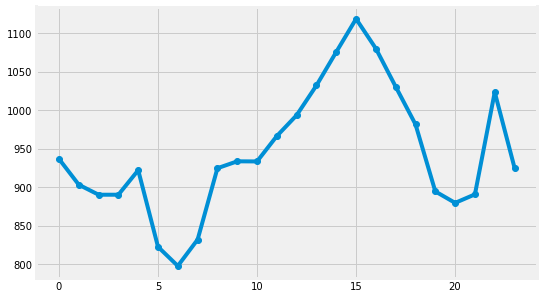

In [85]:
avg_duration_hour = train.groupby(['pickup_hour'])['trip_duration'].mean().reset_index().rename(
    columns={'trip_duration':'avg_trip_duration'})
plt.figure(figsize=(8,5))
plt.plot(train.groupby(['pickup_hour'])['trip_duration'].mean(), 'o-')

여행 시간은 10~15시간 사이에서 증가한다.

### Distribution of Pickups across Days

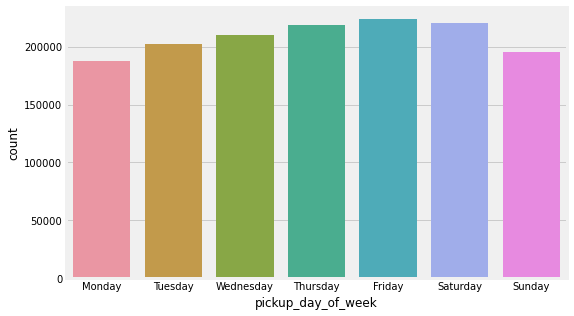

In [87]:
plt.figure(figsize=(8,5))
sns.countplot(train['pickup_day_of_week'], order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'])
plt.show()

승차 건수가 월요일에 매우 낮다. 화요일부터 금요일까지 승차 건수는 점점 증가한다.

### Avg Trip Duration over Days of week

In [88]:
avg_duration_day = train.groupby(['pickup_day_of_week'])['trip_duration'].mean().reset_index().rename(
    columns={'trip_duration':'avg_trip_duration'})

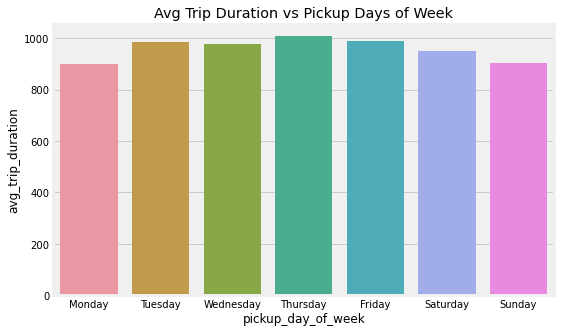

In [90]:
plt.figure(figsize=(8,5))
sns.barplot(x='pickup_day_of_week', y='avg_trip_duration', data=avg_duration_day,
           order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']).set_title('Avg Trip Duration vs Pickup Days of Week')
plt.show()

평균 속도는 목요일에 가장 높다.

### Create a calculated field Bearing

Beraing은 여행의 이동 방향을 측정한다. 공식 : θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ)    λ:경도

In [91]:
def calculateBearing(lat1, lng1, lat2, lng2):
    R = 6371
    lng_delta_rad = np.radians(lng2-lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1,lng1,lat2,lng2))
    y = np.sin(lng_delta_rad)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y,x))

In [92]:
train['bearing'] = train.apply(lambda row: calculateBearing(
    row['pickup_latitude_round3'], row['pickup_longitude_round3'],
    row['dropoff_latitude_round3'], row['dropoff_longitude_round3']), axis=1)

#### Distribution of Bearing

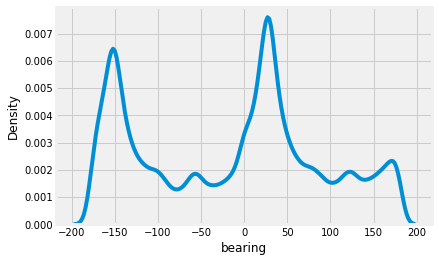

In [97]:
sns.kdeplot(train['bearing'])
plt.show()